This is just going to run the a star algorithm over the maze I saved.
To implement this I need to rerender the maze in a more tractable way, which can help with the more advanced solution I want to persue later.

*Addendum*

After completing the "simple" approach of a star, I have decided not to persue the more complex approach.
The problem is insufficiently interesting to make the more complex approach particularly amusing to persue.
This is not meant as a criticism of the problem - technical tests should be reasonably short.

The more complex approach would be to train a neural network to traverse the maze.
I will quickly describe the methodology of doing so:

 * The input would be the maze, redefined as a 3 dimensional tensor
   The innermost dimension would be `(wall_north, wall_east, wall_south, wall_west, is_exit, is_enemy)`
   The other two dimensions would be the X and Y of the maze cells
   The maze would always be centered on the pony, so considering that the maze can be `25x25` this would be a `49x49x6` tensor.
   Areas outside the maze would be considered to have walls in all directions and would never contain an exit or an enemy.
   
 * The architecture would be a CNN like efficientnet or similar.
   The final layer would be a 1 dimensional tensor of shape 4 which is `(move_north, move_east, move_south, move_west)`.
   A UNet may be considered as that could allow segmentation of the cells into exit-path and non-exit-path.
   It would not be reasonable to use pretrained weights for this so training may take some time.

 * The loss function would be the a star search result, using [cross entropy](https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/) to determine a single loss value.
   This is why implementing the "simple" approach of a star was always valuable for this task.

I would choose a CNN because this task appears similar enough to me to image classification.
The 6 input features can be mapped into the regular structure of the CNN by altering the input layer and expanding it from 3 (RGB) to 6.
Given that I am not using pretrained weights this should not be an issue.

The lack of pretrained weights means the amount of training data would require work.
At the time of writing I have over 300 individual states between 8 mazes.
This is not nearly enough, I would need at least 10k and hopefully even more.
Rather than spamming the API I can generate new states through data augmentation easily.

The augmentation would just place the three entities at random discrete points in the maze.
Given I have a good loss function that can work with this I should be able to turn a maze into $(width * height) * (width * height - 1) * (width * height - 2)$ training examples.
This would easily give me millions of states to train with.

The reason that a UNet may be more appropriate than a regular CNN is that the spatial structure of the maze mean that long distance relationships are as important as local relationships.
The UNet structure is able to join up the local and the distant due to the skip connections.
To perform the final classification I would then add a CNN to the end of the UNet (as the UNet produces output that is the same dimension as the input, this should be fine).
I like to think of this as a Mu (μ) net, however that character faces the wrong way really.
I still like my pun.

In [128]:
from __future__ import annotations
from dataclasses import dataclass
from typing import *
from pathlib import Path
import requests
import json
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import pylab as plt
import shutil
from collections import Counter

In [2]:
MAZE_FILE = Path('data/w15-h15-d0/b1db795c-1747-4889-bfa9-fcf1749dadfb/0000.json')

In [108]:
raw_data = json.loads(MAZE_FILE.read_text())

The simplest way to solve this is to load it as a graph and then use a search algorithm to find the route to the exit.
Manually implementing a-star or whatever is a bit old hat.

In [4]:
G = nx.Graph() # G is the normal name for these graphs

In [5]:
G.add_nodes_from(range(len(raw_data['data'])))

In [6]:
width, height = raw_data["size"]

In [7]:
G.add_edges_from([
    (idx, idx - width)
    for idx, node in enumerate(raw_data['data'])
    if "north" not in node
])
G.add_edges_from([
    (idx, idx - 1)
    for idx, node in enumerate(raw_data['data'])
    if "west" not in node
])

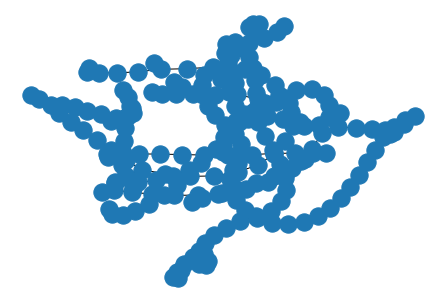

In [26]:
nx.draw(G)

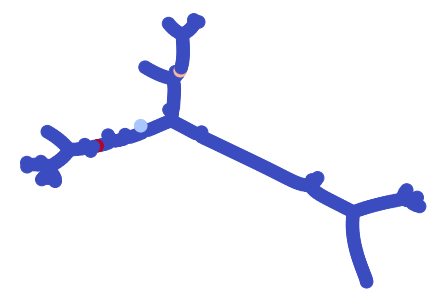

In [115]:
# from stackoverflow when I was debugging the invocation
def to_color(idx: int) -> int:
    if idx == raw_data["pony"][0]:
        return 1 # light blue
    if idx == raw_data["domokun"][0]:
        return 2 # pink
    if idx == raw_data["end-point"][0]:
        return 3 # red
    return 0

nx.draw(
    G,
    pos=graphviz_layout(G),
    node_size=160,
    cmap=plt.cm.coolwarm,
    node_color=[to_color(idx) for idx in range(len(G))],
    prog='dot'
)

The graph vizualisation is never going to show a maze structure, as that is a spatial organization that has little to do with the connectivity of the nodes.
As you can see from the above the path from the pony (light blue) to the exit (red) is reachable without worrying about the domokun (pink).
This is the easiest possible map though.

The other concern I have is that I want to record the state of the board at every turn, I want to programmatically create it, and I want to only evaluate the path once.
All this is fine, I just need to start by evaluating the path.

In [49]:
nx.astar_path(G, raw_data["pony"][0], raw_data["end-point"][0])

[121, 120, 105, 90, 91, 76, 61, 60, 45, 46, 31, 16, 17, 32, 47, 62]

In [50]:
raw_data["pony"][0], raw_data["end-point"][0]

(121, 62)

So this is the inclusive path between these points.
I need to be able to turn this into the cardinal directions.
I believe the maze is oriented such that up is north.

In [55]:
def to_direction(start: int, end: int, width: int) -> str:
    assert start != end
    if start > end: # left or up
        if start - end == 1: # left
            return "west"
        assert start - end == width
        return "north"
    if end - start == 1:
        return "east"
    assert end - start == width
    return "south"

In [56]:
steps = nx.astar_path(G, raw_data["pony"][0], raw_data["end-point"][0])

In [57]:
i_steps = iter(steps)
next(i_steps)
[to_direction(start, end, width) for start, end in zip(steps, i_steps)]

['west',
 'north',
 'north',
 'east',
 'north',
 'north',
 'west',
 'north',
 'east',
 'north',
 'north',
 'east',
 'south',
 'south',
 'south']

When I trace the path through the printed version this is in accordance with it.
So the next thing is to wrap this up in methods and try recording it.

In [116]:
def calculate_path(maze: Dict[str, Any]) -> List[str]:
    pony = maze["pony"][0]
    end = maze["end-point"][0]
    width, _ = maze["size"]

    G = maze_to_graph(maze)
    idx_steps = nx.astar_path(G, pony, end)
    return cardinal_steps(idx_steps, width)

def maze_to_graph(maze: Dict[str, Any]) -> nx.Graph:
    G = nx.Graph()
    G.add_nodes_from(range(len(maze['data'])))
    width, _ = maze["size"]
    G.add_edges_from([
        (idx, idx - width)
        for idx, node in enumerate(maze['data'])
        if "north" not in node
    ])
    G.add_edges_from([
        (idx, idx - 1)
        for idx, node in enumerate(maze['data'])
        if "west" not in node
    ])
    return G

def cardinal_steps(steps: List[int], width: int) -> List[str]:
    i_steps = iter(steps)
    next(i_steps)
    return [to_direction(start, end, width) for start, end in zip(steps, i_steps)]

def to_direction(start: int, end: int, width: int) -> str:
    assert start != end
    if start > end: # left or up
        if start - end == 1: # left
            return "west"
        assert start - end == width
        return "north"
    if end - start == 1:
        return "east"
    assert end - start == width
    return "south"

def plot_maze(G: nx.Graph) -> None:
    nx.draw(
        G,
        pos=graphviz_layout(G),
        node_size=160,
        cmap=plt.cm.coolwarm,
        node_color=[index_to_color(idx) for idx in range(len(G))],
        prog='dot'
    )
    
def index_to_color(idx: int) -> int:
    if idx == raw_data["pony"][0]:
        return 1 # light blue
    if idx == raw_data["domokun"][0]:
        return 2 # pink
    if idx == raw_data["end-point"][0]:
        return 3 # red
    return 0

In [59]:
calculate_path(raw_data)

['west',
 'north',
 'north',
 'east',
 'north',
 'north',
 'west',
 'north',
 'east',
 'north',
 'north',
 'east',
 'south',
 'south',
 'south']

In [60]:
def request_maze(width: int, height: int, difficulty: int) -> str:
    assert 15 <= width <= 25
    assert 15 <= height <= 25
    assert 0 <= difficulty <= 10

    data = {
      "maze-width": width,
      "maze-height": height,
      "maze-player-name": "Rainbow Dash",
      "difficulty": difficulty,
    }
    
    response = requests.post("https://ponychallenge.trustpilot.com/pony-challenge/maze", json=data)
    return response.json()["maze_id"]

In [61]:
maze_id = request_maze(15, 15, 0)

In [62]:
maze_id

'3338469a-241c-4648-b00c-d3ffb347a7ca'

In [63]:
def request_maze_data(maze_id: str) -> Dict[str, Any]:
    assert maze_id
    response = requests.get(f"https://ponychallenge.trustpilot.com/pony-challenge/maze/{maze_id}")
    return response.json()

In [64]:
maze_data = request_maze_data(maze_id)

In [66]:
maze_data.keys()

dict_keys(['pony', 'domokun', 'end-point', 'size', 'difficulty', 'data', 'maze_id', 'game-state'])

In [68]:
def record_maze_data(maze: Dict[str, Any], turn: int, folder: Path) -> None:
    maze_id = maze["maze_id"]
    width, height = maze["size"]
    difficulty = maze["difficulty"]

    maze_folder = folder / f"w{width}-h{height}-d{difficulty}" / maze_id
    if not maze_folder.exists():
        maze_folder.mkdir(parents=True)
    maze_file = maze_folder / f"{turn:04}.json"
    maze_file.write_text(json.dumps(maze))

In [69]:
record_maze_data(maze_data, 0, Path('data'))

In [70]:
path = calculate_path(maze_data)
path

['east',
 'east',
 'east',
 'north',
 'north',
 'west',
 'north',
 'east',
 'north',
 'east',
 'east',
 'east',
 'south',
 'east',
 'south',
 'east',
 'north',
 'east',
 'south',
 'south',
 'west',
 'south',
 'west',
 'north',
 'west',
 'west',
 'west',
 'south',
 'east',
 'east',
 'south',
 'south',
 'east',
 'south',
 'west',
 'west',
 'north',
 'north',
 'west',
 'west',
 'west',
 'west',
 'south',
 'west',
 'west',
 'south',
 'east',
 'east',
 'south',
 'west',
 'west',
 'south',
 'west',
 'north',
 'north',
 'north',
 'west',
 'west',
 'west',
 'south',
 'east',
 'east',
 'south',
 'west',
 'south',
 'west',
 'south',
 'east',
 'south',
 'south',
 'west',
 'south',
 'south',
 'east',
 'east',
 'north',
 'north',
 'east',
 'north',
 'west',
 'north',
 'east',
 'east',
 'east',
 'south',
 'west',
 'south',
 'east',
 'south',
 'west',
 'south',
 'east',
 'east',
 'east',
 'east',
 'north',
 'west',
 'west',
 'north',
 'north',
 'east',
 'south',
 'east',
 'east',
 'south',
 'south',


umm....
I have looked at this maze and that length of solution does seem credible.

In [73]:
def request_and_record_maze_rendition(maze: Dict[str, Any], turn: int, folder: Path) -> Dict[str, Any]:
    maze_id = maze["maze_id"]
    width, height = maze["size"]
    difficulty = maze["difficulty"]

    response = requests.get(f"https://ponychallenge.trustpilot.com/pony-challenge/maze/{maze_id}/print")

    maze_folder = folder / f"w{width}-h{height}-d{difficulty}" / maze_id
    if not maze_folder.exists():
        maze_folder.mkdir(parents=True)
    maze_file = maze_folder / f"{turn:04}-print.txt"
    maze_file.write_text(response.text)

In [74]:
request_and_record_maze_rendition(maze_data, 0, Path('data'))

In [87]:
def request_maze_step(maze_id: str, direction: str) -> None:
    # walking into wall (does advance enemy): { "state": "active", "state-result": "Can't walk in there" }
    # nonsense direction (NOT JSON!): Possible directions east, west, north, south, stay
    # good direction: { "state": "active", "state-result": "Move accepted" }
    # gruesome end: { "state": "over", "state-result": "You lost. Killed by monster", "hidden-url": "/eW91X2tpbGxlZF90aGVfcG9ueQ==.jpg" }
    # https://ponychallenge.trustpilot.com/eW91X2tpbGxlZF90aGVfcG9ueQ==.jpg it's beautiful! (it uses my pony too?)
    data = {
        "direction": direction
    }
    response = requests.post(f"https://ponychallenge.trustpilot.com/pony-challenge/maze/{maze_id}", json=data)
    return response.json() # the end is unusual

In [84]:
maze_id = request_maze(15, 15, 0)

In [85]:
maze_id

'2039d8a3-a571-4885-962b-66335907e713'

In [86]:
maze_data = request_maze_data(maze_id)
maze_data["end-point"][0] = 219 # current position of enemy, want to see death response
path = calculate_path(maze_data)
for step in path:
    request_maze_step(maze_id, step)

In [103]:
DATA_FOLDER = Path('data')

def run_sim(width: int, height: int, difficulty: int):
    maze_id = request_maze(width, height, difficulty)
    print(f"Started maze: {maze_id}")
    
    maze_data = request_maze_data(maze_id)
    plot_maze(maze_to_graph(maze_data))
    record_maze_data(maze_data, 0, DATA_FOLDER)
    request_and_record_maze_rendition(maze_data, 0, DATA_FOLDER)
    path = calculate_path(maze_data)

    for turn, direction in enumerate(path, start=1):
        response = request_maze_step(maze_id, direction)
        print(f"Walked {direction}: {response}")
        if response["state"] != "active":
            break
        maze_data = request_maze_data(maze_id)
        record_maze_data(maze_data, turn, DATA_FOLDER)

In [89]:
run_sim(15, 15, 0)

Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked west: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked west: {'state': 'active', 'state-result': 'Move accepted'}
Walked west: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'over', 'state-result': 'You lost. Killed by monster', 'hidden-url': '/eW91X2tpbGxlZF90aGVfcG9ueQ==.jpg'}
Walked west: {'state': 'over', 'state-result': 'You lost. Killed by monster', 'hidden-url': '/eW91X2tpbGxlZF90aGVfcG9ueQ==.jpg'}
Walked south: {'state': 'over', 'state-result': 'You lost. Killed by monster', 'hidden-url': '/eW91X2tpbGxlZF90aGVfcG9ueQ==.jpg'}
Walked west: {'state': 'over', 'state-result': 'You lost. Killed by monster', 'hidden-url': '/eW91X2tpbGxlZF90aGVfcG9ueQ==.jpg'}
Walked south: {'state': 'over', 'state-result': 'You lost. Killed by monster', 'hidden-url': '/eW91X2tpbGxlZF90aGVfcG9ueQ==.jpg'}
Walked south: {'stat

Brutal.

In [92]:
run_sim(15, 15, 0)

Started maze: 9b6fa8bc-cecd-46aa-b312-972f60a89493
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked west: {'state': 'active', 'state-result': 'Move accepted'}
Walked west: {'state': 'active', 'state-result': 'Move accepted'}
Walked west: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked west: {'sta

In [94]:
run_sim(15, 15, 0)

Started maze: 8e64e451-464b-4c72-a297-16f5f55f811b
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked west: {'s

So dodging the monster is an actual problem.
Lets see what increasing the difficulty is like.

In [98]:
run_sim(15, 15, 10)

Started maze: 196fa7b9-3d2b-4d56-96e1-0c7719b495c3
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: 

I'm going to guess that this has a monster that actively chases you?

In [101]:
run_sim(25, 25, 10)

Started maze: 715c4d35-ad86-4716-ab89-7e1558fbf076
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked west: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked west: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'sta

In [102]:
run_sim(25, 25, 10)

Started maze: 8d9e07b6-bdd9-447b-9b18-094d99ca982a
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked west: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked west: {'s

So there does not appear to be any bonus to doing harder difficulties.
It would be good to be able to avoid the monster.

Started maze: 1f0a88cb-93c1-4240-a5f5-fd5c0b93e1a0
Walked west: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked west: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'s

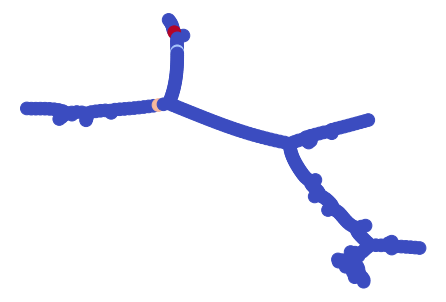

In [117]:
run_sim(15, 15, 0)

I'm not sure how good these visualisations are. There were a huge number of steps then. There is little in the way of meaningful choice in the maze.

Started maze: 841416f7-acb5-476d-ac60-24b43c3cdb51
Walked west: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked north: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked east: {'state': 'active', 'state-result': 'Move accepted'}
Walked south: {'

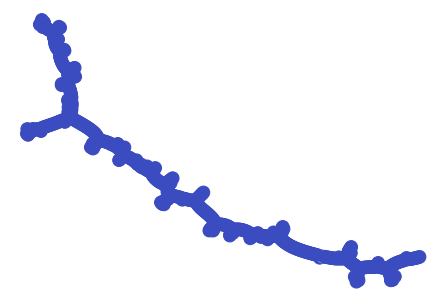

In [118]:
run_sim(25, 25, 10)

The problem I have with taking this further is that the whole maze problem is split in two.
I don't think there are cycles in the maze.
Given this the enemy state is one of:
 * Behind you
 * Directly between you and the end
 * On a branch that does not lead to the end but is connected between you and the end
 * After the end

If the enemy is behind you then you are sure to win.
Otherwise you have a chance of losing depending on factors like the distance of the enemy from the path you will take and the enemy moves chosen.

If the enemy moves randomly then waiting for it to get out of the way, or actively avoiding it, is the only way to meaningfully affect the result.
If the enemy does not move randomly then you are doomed come what may.

I think this is a reasonable solution and I don't really see what putting this data into a neural net would achieve.
I currently have 368 board states which would be the start of a training set.

After thinking about this for a bit I wonder if the "difficulty" is the range of the path finding for the enemy. If you are <= difficulty steps from the monster then it will walk towards you, otherwise it will walk randomly.

I have enough data to be able to test this hypothesis.
The way to determine this is simple:
* Determine the path from the enemy to the pony
* Count the steps
* Record the index that the enemy would move into if they were moving to the pony
* Review the next turn and determine if the enemy moved in a way consistent with that

With the difficulty, step count and the boolean moved towards state it should be possible to determine when the enemy stops moving randomly.

At this point it is unknown if the enemy selects from all possible moves (north / east / south / west / stay) when moving randomly. If it does then I would expect it to frequently fail to move. The proportion of times that it fails to move towards the pony should be sufficient to indicate if it can stay.

The aim of determining this fact would be to allow the pony to remain distant from the enemy until the enemy moves itself from the path to the exit.
This doesn't feel particularly thrilling, so at this point I just wish to determine if it occurs.

In [119]:
list(DATA_FOLDER.glob("w*-h*-d0/*"))

[PosixPath('data/w15-h15-d0/c1149903-32bc-4b82-9c99-7245f341036f'),
 PosixPath('data/w15-h15-d0/9b6fa8bc-cecd-46aa-b312-972f60a89493'),
 PosixPath('data/w15-h15-d0/5f15bfc3-1339-4dc0-8c88-776c78c204a2'),
 PosixPath('data/w15-h15-d0/3338469a-241c-4648-b00c-d3ffb347a7ca'),
 PosixPath('data/w15-h15-d0/054de2a6-9d0a-49a7-b033-64b34f7e5834'),
 PosixPath('data/w15-h15-d0/b1db795c-1747-4889-bfa9-fcf1749dadfb'),
 PosixPath('data/w15-h15-d0/8e64e451-464b-4c72-a297-16f5f55f811b'),
 PosixPath('data/w15-h15-d0/1f0a88cb-93c1-4240-a5f5-fd5c0b93e1a0')]

In [125]:
for folder in DATA_FOLDER.glob("w*-h*-d0/*"):
    recording_count = len(list(folder.glob('*.json')))
    print(f"{folder} -> {recording_count}")
    if recording_count == 1:
        print(f"Deleting {folder}")
        shutil.rmtree(folder)

data/w15-h15-d0/c1149903-32bc-4b82-9c99-7245f341036f -> 1
Deleting data/w15-h15-d0/c1149903-32bc-4b82-9c99-7245f341036f
data/w15-h15-d0/9b6fa8bc-cecd-46aa-b312-972f60a89493 -> 1
Deleting data/w15-h15-d0/9b6fa8bc-cecd-46aa-b312-972f60a89493
data/w15-h15-d0/5f15bfc3-1339-4dc0-8c88-776c78c204a2 -> 32
data/w15-h15-d0/3338469a-241c-4648-b00c-d3ffb347a7ca -> 1
Deleting data/w15-h15-d0/3338469a-241c-4648-b00c-d3ffb347a7ca
data/w15-h15-d0/054de2a6-9d0a-49a7-b033-64b34f7e5834 -> 36
data/w15-h15-d0/b1db795c-1747-4889-bfa9-fcf1749dadfb -> 1
Deleting data/w15-h15-d0/b1db795c-1747-4889-bfa9-fcf1749dadfb
data/w15-h15-d0/8e64e451-464b-4c72-a297-16f5f55f811b -> 93
data/w15-h15-d0/1f0a88cb-93c1-4240-a5f5-fd5c0b93e1a0 -> 56


In [126]:
for folder in DATA_FOLDER.glob("w*-h*-d0/*"):
    recording_count = len(list(folder.glob('*.json')))
    print(f"{folder} -> {recording_count}")

data/w15-h15-d0/5f15bfc3-1339-4dc0-8c88-776c78c204a2 -> 32
data/w15-h15-d0/054de2a6-9d0a-49a7-b033-64b34f7e5834 -> 36
data/w15-h15-d0/8e64e451-464b-4c72-a297-16f5f55f811b -> 93
data/w15-h15-d0/1f0a88cb-93c1-4240-a5f5-fd5c0b93e1a0 -> 56


In [131]:
def investigate_enemy_moves(folder: Path) -> Counter:
    files = sorted(folder.glob("*.json"))
    files_iter = iter(files)
    next(files_iter)
    results = Counter([
        consider_enemy_move(current, following)
        for current, following in zip(files, files_iter)
    ])
    return results

def consider_enemy_move(current: Path, following: Path) -> Tuple[int, bool]:
    maze = json.loads(current.read_text())
    G = maze_to_graph(maze)
    steps = nx.astar_path(G, maze["domokun"][0], maze["pony"][0])
    next_enemy = json.loads(following.read_text())["domokun"][0]
    return (len(steps), steps[1] == next_enemy)

In [132]:
investigate_enemy_moves(Path("data/w15-h15-d0/5f15bfc3-1339-4dc0-8c88-776c78c204a2"))

Counter({(53, True): 1,
         (51, True): 1,
         (49, True): 1,
         (47, False): 1,
         (47, True): 1,
         (45, False): 1,
         (45, True): 1,
         (43, True): 1,
         (41, False): 2,
         (41, True): 1,
         (39, True): 1,
         (37, True): 1,
         (35, False): 2,
         (35, True): 1,
         (33, False): 2,
         (33, True): 1,
         (31, False): 1,
         (31, True): 1,
         (29, False): 1,
         (29, True): 1,
         (27, False): 1,
         (27, True): 1,
         (25, True): 1,
         (23, False): 1,
         (23, True): 1,
         (21, False): 3})

Hypothesis time!

Question: Is the movement random, and how?

Iff random in 4 directions then on average
 * Collide with wall would be 1/2 of the time
 * Move away would be 1/4
 * So move towards would be 1/4

Iff random in 4 directions and stay then on average
 * Stay would be 1/5 of the time
 * Collide with wall would be 2/5 of the time
 * Move away would be 1/5
 * So move towards would be 1/5

Iff random in valid directions then on average
 * Move away would be 1/2
 * So move towards would be 1/2

Iff random in valid directions and stay then on average
 * Stay would be 1/3 of the time
 * Move away would be 1/3
 * So move towards would be 1/3

In [141]:
d0_results = dict(sum([
    investigate_enemy_moves(folder)
    for folder in DATA_FOLDER.glob("w*-h*-d0/*")
], Counter()
))

# sorted(d0_results.items())

display(sum([
    Counter({towards: count})
    for (_, towards), count in d0_results.items()
], Counter()))

Counter({True: 100, False: 113})

In [143]:
{(distance, towards): count for (distance, towards), count in d0_results.items() if distance < 5}

{(4, False): 1, (4, True): 1}

In [149]:
(
    sum(count for (distance, _), count in d0_results.items() if distance <= 10),
    sum(count for (distance, _), count in d0_results.items())
)

(17, 213)

The results of $P(towards) = 100 / 213$ suggests that the behaviour is valid directions.

* The expected result of valid directions would be $P(towards) = 100 / 200$.
* The expected result of valid directions and stay (closest alternative) would be $P(towards) = 100 / 300$.

These ratios assume that the enemy is never on a junction.
When the enemy is on a junction they have N - 1 moves that are away from the pony.
That could explain the slight increase in the movement away from the pony.

This is testing difficulty zero and the closest recorded distance is 4 steps.
As you can see the only recorded instances of 4 step distances have the enemy moving in both directions, so forced movement has not occurred.

As a setup for the next hypothesis we have determined that the enemy is within 10 paces of the pony $17 / 213$ of the time.

Hypothesis time!

Question: Is the movement random when at difficulty 10, and how?

If the movement is forced when the distance is 10 steps or less then I would expect to see an increase above 1/2 for the movement toward the pony.
Given the previous distance split this would manifest itself as something in the region of 10% more movement toward the pony.

In [145]:
d10_results = dict(sum([
    investigate_enemy_moves(folder)
    for folder in DATA_FOLDER.glob("w*-h*-d10/*")
], Counter()
))

display(sum([
    Counter({towards: count})
    for (_, towards), count in d10_results.items()
], Counter()))

Counter({True: 142})

That's kinda hilarious.

So at difficulty 10 the enemy always moves towards the pony.

Given this result there is no high difficulty approach more optimal than just going for the exit.
I should point out that if you are ever within seek range of the enemy then it will approach you as fast as you can flee, so you can never leave the seek range.
Given that you have a random start that may be within the seek range you have no benefit in trickery, except at low difficulty levels.